# Universidad Del Valle de Guatemala
## Deep Learning
### Proyecto Final: Red Neuronal que predice si el Barcelona ganara un partido.
#### Integrantes: 
- Roberto Rios 20979
- Javier Mombiela 20067

In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#### Obtenemos la data

In [3]:
data = pd.read_csv('temporadas.csv')

Visualizacion de data

In [4]:
print(data.count())
data

Date        3800
HomeTeam    3800
AwayTeam    3800
FTHG        3800
FTAG        3800
FTR         3800
HTHG        3800
HTAG        3800
HTR         3800
HS          3800
AS          3800
HST         3800
AST         3800
HF          3800
AF          3800
HC          3800
AC          3800
HY          3800
AY          3800
HR          3800
AR          3800
dtype: int64


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,17/08/13,Sociedad,Getafe,2,0,H,1,0,H,16,...,6,2,13,6,6,5,1,1,0,0
1,17/08/13,Valencia,Malaga,1,0,H,0,0,D,9,...,1,2,15,23,9,6,3,5,0,0
2,17/08/13,Valladolid,Ath Bilbao,1,2,A,1,1,D,8,...,2,3,10,8,5,5,1,0,0,0
3,18/08/13,Barcelona,Levante,7,0,H,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
4,18/08/13,Osasuna,Granada,1,2,A,0,2,A,14,...,5,4,15,17,7,6,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,04/06/2023,Betis,Valencia,1,1,D,1,0,H,8,...,3,3,11,11,5,4,3,0,0,1
3796,04/06/2023,Celta,Barcelona,2,1,H,1,0,H,12,...,9,2,13,9,2,4,2,2,0,0
3797,04/06/2023,Elche,Cadiz,1,1,D,0,1,A,12,...,5,3,18,8,7,4,4,3,0,0
3798,04/06/2023,Espanol,Almeria,3,3,D,1,1,D,12,...,8,4,11,12,7,6,2,3,0,0


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

C:\Users\rjmom\AppData\Local\Temp\ipykernel_8504\1555408434.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG                 int64
FTAG                 int64
FTR                 object
HTHG                 int64
HTAG                 int64
HTR                 object
HS                   int64
AS                   int64
HST                  int64
AST                  int64
HF                   int64
AF                   int64
HC                   int64
AC                   int64
HY                   int64
AY                   int64
HR                   int64
AR                   int64
dtype: object

#### Preprocesamiento de datos

Codificacion de etiquetas para los equipos y variables objetivo FTR (Full Time Result)

In [6]:
team_label_encoder = LabelEncoder()
data['HomeTeam'] = team_label_encoder.fit_transform(data['HomeTeam'])
data['AwayTeam'] = team_label_encoder.fit_transform(data['AwayTeam'])

Ver la codificacion de las variables

In [7]:
team_mapping = dict(zip(team_label_encoder.classes_, team_label_encoder.transform(team_label_encoder.classes_)))

team_mapping = {k: int(v) for k, v in team_mapping.items()}
with open('modelos/team_mapping.json', 'w') as f:
    json.dump(team_mapping, f)

print(team_mapping)

{'Alaves': 0, 'Almeria': 1, 'Ath Bilbao': 2, 'Ath Madrid': 3, 'Barcelona': 4, 'Betis': 5, 'Cadiz': 6, 'Celta': 7, 'Cordoba': 8, 'Eibar': 9, 'Elche': 10, 'Espanol': 11, 'Getafe': 12, 'Girona': 13, 'Granada': 14, 'Huesca': 15, 'La Coruna': 16, 'Las Palmas': 17, 'Leganes': 18, 'Levante': 19, 'Malaga': 20, 'Mallorca': 21, 'Osasuna': 22, 'Real Madrid': 23, 'Sevilla': 24, 'Sociedad': 25, 'Sp Gijon': 26, 'Valencia': 27, 'Valladolid': 28, 'Vallecano': 29, 'Villarreal': 30}


In [8]:
data.describe()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,3800,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,2018-07-20 02:24:45.473684224,15.055000,15.055000,1.513158,1.124474,0.664474,0.488947,13.231579,10.488684,4.671579,3.663421,13.680000,13.567632,5.476053,4.256316,2.412368,2.627632,0.116053,0.133684
min,2013-01-09 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016-01-17 18:00:00,6.000000,6.000000,1.000000,0.000000,0.000000,0.000000,10.000000,7.000000,3.000000,2.000000,11.000000,11.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000
50%,2018-07-22 00:00:00,14.000000,14.000000,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,4.000000,3.000000,13.000000,13.000000,5.000000,4.000000,2.000000,3.000000,0.000000,0.000000
75%,2021-01-31 00:00:00,24.000000,24.000000,2.000000,2.000000,1.000000,1.000000,16.000000,13.000000,6.000000,5.000000,16.000000,16.000000,7.000000,6.000000,3.000000,4.000000,0.000000,0.000000
max,2023-12-05 00:00:00,30.000000,30.000000,10.000000,8.000000,6.000000,5.000000,36.000000,35.000000,17.000000,15.000000,33.000000,30.000000,20.000000,17.000000,9.000000,9.000000,2.000000,3.000000
std,NaN,9.445923,9.445923,1.320595,1.126638,0.839158,0.713414,4.848432,4.359156,2.537849,2.154137,4.168562,4.175368,2.865495,2.517867,1.518753,1.515568,0.339479,0.362092


Filtrar datos en los que jugo el barcelona solamente

In [9]:
barcelona = team_mapping['Barcelona']

data = data[(data['HomeTeam'] == barcelona) | (data['AwayTeam'] == barcelona)]
data.describe()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,380,380.000000,380.000000,380.000000,380.000000,380.00000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,2018-07-18 20:35:22.105263104,9.818421,9.818421,1.863158,1.439474,0.85000,0.581579,13.736842,11.065789,5.489474,4.284211,13.150000,12.207895,5.384211,4.155263,2.136842,2.431579,0.134211,0.102632
min,2013-01-09 00:00:00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016-01-31 12:00:00,4.000000,4.000000,0.000000,0.000000,0.00000,0.000000,9.000000,7.000000,3.000000,2.000000,10.000000,9.000000,3.000000,2.000000,1.000000,1.750000,0.000000,0.000000
50%,2018-07-07 00:00:00,4.000000,4.000000,2.000000,1.000000,1.00000,0.000000,13.000000,10.000000,5.000000,4.000000,13.000000,12.000000,5.000000,4.000000,2.000000,2.000000,0.000000,0.000000
75%,2021-02-10 18:00:00,16.000000,16.000000,3.000000,2.000000,1.00000,1.000000,17.250000,14.000000,7.250000,6.000000,16.000000,15.000000,7.000000,6.000000,3.000000,3.000000,0.000000,0.000000
max,2023-12-03 00:00:00,30.000000,30.000000,8.000000,8.000000,6.00000,3.000000,31.000000,29.000000,17.000000,13.000000,28.000000,30.000000,15.000000,14.000000,8.000000,7.000000,2.000000,2.000000
std,NaN,8.810295,8.810295,1.721266,1.450692,1.01239,0.793228,5.585432,4.991115,3.073831,2.656850,4.661766,4.262055,3.034501,2.783214,1.545172,1.486279,0.363780,0.328896


Agregamos una columna con el resultado del partido (0 = Barca perdio, 1 = Barca gano)

In [10]:
data['Resultado'] = 0

data.loc[(data['HomeTeam'] == barcelona) & (data['FTR'] == 'H'), 'Resultado'] = 1
data.loc[(data['AwayTeam'] == barcelona) & (data['FTR'] == 'A'), 'Resultado'] = 1
data.tail()

C:\Users\rjmom\AppData\Local\Temp\ipykernel_8504\2062008536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Resultado'] = 0


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Resultado
3758,2023-05-14,11,4,2,4,A,0,3,A,15,...,5,12,9,4,3,1,3,0,0,1
3765,2023-05-20,4,25,1,2,A,0,1,A,13,...,6,8,16,8,2,4,4,0,0,0
3772,2023-05-23,28,4,3,1,H,2,0,H,8,...,6,13,9,2,6,1,0,0,0,0
3784,2023-05-28,4,21,3,0,H,2,0,H,28,...,1,4,9,14,3,0,0,0,1,1
3796,2023-04-06,7,4,2,1,H,1,0,H,12,...,2,13,9,2,4,2,2,0,0,0


#### Agregar estadisticas a la data

Funcion para determinar el rolling average de los ultimos 10 partidos

In [11]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('Date')
    rolling_stats = group[cols].rolling(10, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [12]:
cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
new_cols = [f'{col}_avg' for col in cols]
new_cols

['FTHG_avg',
 'FTAG_avg',
 'HTHG_avg',
 'HTAG_avg',
 'HS_avg',
 'AS_avg',
 'HST_avg',
 'AST_avg',
 'HF_avg',
 'AF_avg',
 'HC_avg',
 'AC_avg',
 'HY_avg',
 'AY_avg',
 'HR_avg',
 'AR_avg']

In [13]:
# Asumiendo que 'team_mapping' es tu mapeo de equipos
teams = list(team_mapping.values())

# Inicializar las nuevas columnas en 'data'
for col in new_cols:
    data[col] = np.nan

# Aplicar la función a cada equipo
for team in teams:
    team_data = data[(data['HomeTeam'] == team) | (data['AwayTeam'] == team)]
    team_data = rolling_averages(team_data, cols, new_cols)
    data.update(team_data)

# Eliminar las filas con valores NaN (que son el resultado de la media móvil)
data = data.dropna(subset=new_cols)
data

C:\Users\rjmom\AppData\Local\Temp\ipykernel_8504\3136872281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.nan
C:\Users\rjmom\AppData\Local\Temp\ipykernel_8504\3136872281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.nan
C:\Users\rjmom\AppData\Local\Temp\ipykernel_8504\3136872281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST_avg,AST_avg,HF_avg,AF_avg,HC_avg,AC_avg,HY_avg,AY_avg,HR_avg,AR_avg
81,2013-10-19,22,4,0,0,D,0,0,D,4,...,6.9,4.4,13.6,14.4,6.0,5.2,1.6,2.6,0.0,0.0
91,2013-10-26,4,23,2,1,H,1,0,H,12,...,6.5,4.5,14.2,13.3,5.3,5.5,1.8,2.5,0.0,0.0
100,2013-10-29,7,4,0,3,A,0,1,A,12,...,6.4,4.9,14.5,13.9,5.3,5.3,1.7,2.6,0.0,0.0
126,2013-10-11,5,4,1,4,A,0,2,A,16,...,7.4,4.5,13.8,14.3,5.6,5.9,1.5,2.7,0.0,0.0
133,2013-11-23,4,14,4,0,H,2,0,H,13,...,6.0,5.6,15.5,13.6,5.1,5.6,2.0,2.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,2023-05-14,11,4,2,4,A,0,3,A,15,...,4.1,3.9,14.3,13.2,5.5,4.6,2.7,2.9,0.3,0.4
3765,2023-05-20,4,25,1,2,A,0,1,A,13,...,5.1,4.2,12.8,11.3,3.6,4.1,1.9,2.0,0.0,0.0
3772,2023-05-23,28,4,3,1,H,2,0,H,8,...,5.7,3.0,11.2,12.1,5.2,3.2,1.8,2.8,0.1,0.1
3784,2023-05-28,4,21,3,0,H,2,0,H,28,...,5.4,3.3,11.3,11.7,4.6,3.7,1.5,2.5,0.1,0.1


#### Procesamiento de datos

Seleccionar las columnas a utilizar como caracteristicas y la columna objetivo que en este caso es 'Resultado', la cual tiene dos opciones 1 (Barcelona gana), 0 (Barcelona empata o pierde)

In [14]:
features = ['HomeTeam', 'AwayTeam'] + new_cols

X = data[features]
y = data['Resultado']

Dividimos la data en conjunto de entrenamiento y prueba

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### Creamos el modelo

In [16]:
model = Sequential()
model.add(Dense(32, input_dim=len(X_train.columns), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenamos el modelo

In [17]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


10/10 [==============================] - 1s 24ms/step - loss: 0.9170 - accuracy: 0.4527 - val_loss: 0.6869 - val_accuracy: 0.5811
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6511 - accuracy: 0.6959 - val_loss: 0.6635 - val_accuracy: 0.6757
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6311 - accuracy: 0.6892 - val_loss: 0.6153 - val_accuracy: 0.6757
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6072 - accuracy: 0.6926 - val_loss: 0.6142 - val_accuracy: 0.6622
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6030 - accuracy: 0.6959 - val_loss: 0.6148 - val_accuracy: 0.6757
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.5982 - accuracy: 0.6926 - val_loss: 0.6141 - val_accuracy: 0.6757
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6018 - accuracy: 0.7027 - val_loss: 0.6178 - val_accuracy: 0.6892
Epoch 8/10
10/10 [============

Revisamos si hay overfitting

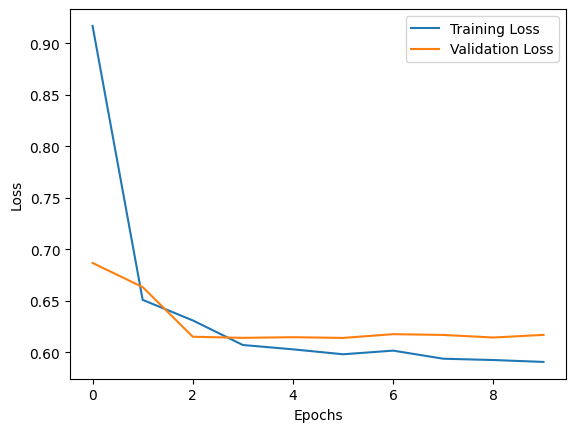

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predicciones

Obtener la exactitud del modelo

In [19]:
y_pred = model.predict(X_test)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

3/3 [==============================] - 0s 2ms/step
Accuracy: 0.6891891891891891


Comparaciones de las predicciones y valores reales

In [20]:
comparison = pd.DataFrame({'Real': y_test[:10], 'Predicted': y_pred[:10]})
print(comparison)

      Real  Predicted
3378     1          1
433      1          1
256      1          1
3256     1          1
673      1          1
2499     1          1
868      1          1
1295     1          1
3158     0          1
1362     1          1


Matriz de confusion

In [21]:
combined = pd.DataFrame({'Real': y_test, 'Prediccion': y_pred})
pd.crosstab(index=combined['Real'], columns=combined['Prediccion'])

Prediccion,1
Real,
0,23
1,51


In [22]:
combined = combined.merge(data[['HomeTeam', 'AwayTeam']], left_index=True, right_index=True)
combined

,Real,Prediccion,HomeTeam,AwayTeam
3378,1,1,4,21
433,1,1,4,14
256,1,1,4,1
3256,1,1,0,4
673,1,1,4,1
...,...,...,...,...
930,0,1,11,4
1042,1,1,4,12
2057,1,1,19,4
3218,0,1,24,4
